# ML Challenge: Stacking using Scikit-Learn

## Challenge description

**Objective**: Create a cross-validation to compare different ML models and a stacking model on a classification task

**Skills practiced**:
    - Model Selection
    - Stacking model
    - Cross-validation
    - Performance evaluation
    - Results visualization

## Challenge Requirements

1. Compare different classification models to a stacking model using the same models
2. Implement a repeated stratified k-fold cross-validation
3. Evaluate using ROC AUC score
4. Create a sorted summary table of model performance
5. Visualize the results

In [16]:
# Import data libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Generate synthetic classification data
from sklearn.datasets import make_classification

# EXECUTE THIS CELL
X, y = make_classification(
    n_samples=1000, 
    n_features=10, 
    n_informative=6, 
    n_redundant=4, 
    n_classes=2, 
    random_state=42
)

## Starter Code

*This section gives you a starting point. Complete the code where indicated.*

## STEP 1: Import the required models
*HINT: Consider logistic regression, k-NN, decision tree,  random forest, extratrees, XGBoost, LightGBM, Catboost, SVM, naive Bayes, and the stacking classifier*


In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

## STEP 2: Initialize models
*HINT: Store models in a dictionary (`models`) with appropriate names*

In [18]:
models = {}
models["LR"] = LogisticRegression(n_jobs=-1, random_state=42, max_iter=10000)
models["KNN"] = KNeighborsClassifier(n_jobs=-1)
models["DTC"] = DecisionTreeClassifier(random_state=42)
models["RF"] = RandomForestClassifier(random_state=42, n_jobs=-1)
models["ETC"] = ExtraTreesClassifier(n_jobs=-1, random_state=42)
models["XGB"] = XGBClassifier(random_state=42, device="cuda")
models["SVC"] = SVC(random_state=42, probability=True)
models["GaussianNB"] = GaussianNB()

## STEP 3: Based on your initialized model create a list of base model for the stacking model

*HINT: StackingClassifier demand a list of model to feed its estimator argument*

In [19]:
base_model_list = [(name, model) for name, model in models.items()]
print(base_model_list)

[('LR', LogisticRegression(max_iter=10000, n_jobs=-1, random_state=42)), ('KNN', KNeighborsClassifier(n_jobs=-1)), ('DTC', DecisionTreeClassifier(random_state=42)), ('RF', RandomForestClassifier(n_jobs=-1, random_state=42)), ('ETC', ExtraTreesClassifier(n_jobs=-1, random_state=42)), ('XGB', XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
          

## STEP 4: Create a meta model and the final stacking model
*HINT: Add the stacking model to the models dictionary*

In [24]:
meta_model = LogisticRegression(solver='liblinear', C=1, penalty='l1')
from sklearn.ensemble import StackingClassifier
stacking_model = StackingClassifier(
    estimators=base_model_list,
    final_estimator=meta_model,
    cv=5,
    stack_method="predict_proba",
    n_jobs=-1
)
models["Stacking_5KFOLDS"] = stacking_model

## STEP 5: Set up cross-validation
*HINT: Use RepeatedStratifiedKFold with 5 folds and 2 repetitions*

In [25]:
from sklearn.model_selection import RepeatedStratifiedKFold

rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)

## STEP 6: Perform cross-validation and collect results
*HINT: Use ROC AUC as evaluation metric, and store mean and standard deviation of scores in a `results` dictionary

In [26]:
from sklearn.model_selection import cross_val_score

results = {}
for name, model in models.items():
    scores = cross_val_score(
        estimator=model,
        X=X,
        y=y,
        scoring="roc_auc",
        cv=rskf,
        n_jobs=-1
    )
    mean_scores = np.mean(scores)
    std_scores = np.std(scores)
    results[name] = {
        "mean_roc" : mean_scores,
        "std_roc" : std_scores
    }

## STEP 7: Create and display a sorted summary table
*HINT: Convert result to DataFrame and sort by performance*

In [27]:
results_df = pd.DataFrame.from_dict(results, columns=["mean_roc", "std_roc"], orient="index")
results_df.index.name = "models"
results_df = results_df.sort_values(by="mean_roc", ascending=False)
results_df

,mean_roc,std_roc
models,,
Stacking_5KFOLDS,0.978250,0.004746
ETC,0.977094,0.004295
RF,0.968039,0.007467
KNN,0.967579,0.008428
SVC,0.964639,0.010483
XGB,0.964374,0.007609
GaussianNB,0.907638,0.026893
LR,0.892997,0.020182
DTC,0.851972,0.011486


## STEP 8: Visualize the results
*HINT: Create a bar chart with errors bars representing standard deviation*

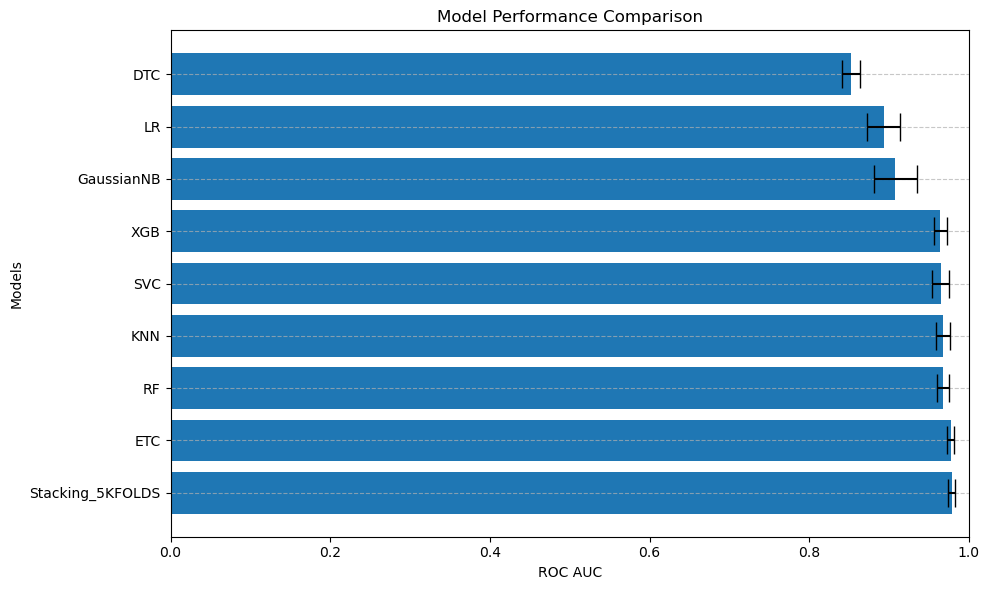

In [28]:
plt.figure(figsize=(10,6))
plt.barh(results_df.index, results_df["mean_roc"], xerr=results_df["std_roc"], capsize=10)
plt.xlabel("ROC AUC")
plt.ylabel("Models")
plt.title("Model Performance Comparison")
plt.xlim(0., 1.0)
plt.grid(axis="y", linestyle=("--"), alpha=0.7)
plt.tight_layout()
plt.show()